# Session 10: Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

## 🤝 Breakout Room #1
  - Task 1: Installing Required Libraries
  - Task 2: Set Environment Variables
  - Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  - Task 4: Construct our RAG application
  - Task 5: Evaluating our Application with Ragas
  - Task 6: Making Adjustments and Re-Evaluating
  - ***Activity #1: Implement a Different Reranking Strategy***


## Task 1: Installing Required Libraries

If you have not already done so, install the required libraries using the uv package manager:
``` bash

uv sync

```


## Task 2: Set Environment Variables:

We'll also need to provide our API keys.
> NOTE: In addition to OpenAI's models, this notebook will be using Cohere's Reranker - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

You have two options for supplying your API keys in this session:
- Use environment variables (see Prerequisite #2 in the README.md)
- Provide them via a prompt when the notebook runs

The following code will load all of the environment variables in your `.env`. Then, it checks for the two API keys we need. If they are not there, it will prompt you to provide them.

First, OpenAI's for our LLM/embedding model combination!

Second, Cohere's for our reranking


In [1]:
import os
from getpass import getpass
from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

if not os.environ.get("COHERE_API_KEY"):
    os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")

In [30]:
os.environ["COHERE_API_KEY"] = getpass("Please enter your Cohere API key!")

## Task 3: Synthetic Dataset Generation for Evaluation using Ragas

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data using the Health & Wellness Guide - a comprehensive resource covering exercise, nutrition, sleep, and stress management.

Next, let's load our data into a familiar LangChain format using the `TextLoader`.

In [109]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("data/HealthWellnessGuide.txt")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [110]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [111]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/1 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/1 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/1 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/4 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/9 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

In [5]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How do you perform pelvic tilts for lower back...,[The Personal Wellness Guide A Comprehensive R...,"To perform pelvic tilts, lie on your back with...",single_hop_specifc_query_synthesizer
1,Wut r partial crunches gud for?,[The Personal Wellness Guide A Comprehensive R...,Partial crunches r recommended for lower back ...,single_hop_specifc_query_synthesizer
2,Wut duz Chaptur 9 say abot insomnya and how ca...,[PART 3: SLEEP AND RECOVERY Chapter 7: The Sci...,Chapter 9 explains that insomnia is difficulty...,single_hop_specifc_query_synthesizer
3,What is Cognitive Behavioral Therapy for Insom...,[PART 3: SLEEP AND RECOVERY Chapter 7: The Sci...,Cognitive Behavioral Therapy for Insomnia (CBT...,single_hop_specifc_query_synthesizer
4,What practical tips does Chapter 17 offer for ...,[PART 5: BUILDING HEALTHY HABITS Chapter 13: T...,Chapter 17 recommends supporting digestive hea...,single_hop_specifc_query_synthesizer
5,uh what Chapter 19 say bout work-life balance?...,[PART 5: BUILDING HEALTHY HABITS Chapter 13: T...,Chapter 19 say keeping balance between work an...,single_hop_specifc_query_synthesizer
6,What sleep hygiene practices from Chapter 8 ca...,[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,Chapter 8 recommends several sleep hygiene pra...,multi_hop_specific_query_synthesizer
7,How do the recommendations from Chapter 7 on i...,[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,Chapter 7 emphasizes the importance of sleep f...,multi_hop_specific_query_synthesizer
8,How do the sleep hygiene practices recommended...,[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,The sleep hygiene practices outlined in Chapte...,multi_hop_specific_query_synthesizer
9,Drawing on the information from Chapter 7 abou...,[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,Optimizing both sleep quality and digestive ha...,multi_hop_specific_query_synthesizer


## Task 4: Construct our RAG application

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [6]:
loader = TextLoader("data/HealthWellnessGuide.txt")
docs = loader.load()

Now that we have our data loaded, let's split it into chunks!

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=50, chunk_overlap=0)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

447

### ❓ Question #1:

What is the purpose of the `chunk_overlap` parameter in the `RecursiveCharacterTextSplitter`?

##### Answer:

Overlapping chunks means part of the content is the same in adjacent chunks. It makes it easier to relate adjacent chunks semantically if they share some common context which is often likely since consecutive paragaraphs or pages of text are likely to be about the same topic, execpt in circumstances where a chunk end corresponds with a topic switch, say a Chapter end (and the following chapter is about a diffent topic).

Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [8]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [9]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="use_case_data",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="use_case_data",
    embedding=embeddings,
)

We can now add our documents to our vector store.

In [10]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [11]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

Now we can produce a node for retrieval!

In [96]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### A - Augmented

Let's create a simple RAG prompt!

In [97]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### G - Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-nano` to avoid using the same model as our judge model.

In [98]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

Then we can create a `generate` node!

In [99]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = llm.invoke(messages)
  return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [100]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [101]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Let's do a test to make sure it's doing what we'd expect.

In [102]:
response = graph.invoke({"question" : "What exercises help with lower back pain?"})

In [103]:
response["response"]

'The provided context does not specify any particular exercises that help with lower back pain.'

## Task 5: Evaluating our Application with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [104]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [105]:
dataset.samples[0].eval_sample.response

'The provided context does not include specific instructions on how to perform pelvic tilts for lower back pain relief.'

Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [106]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [107]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

Next up - we simply evaluate on our desired metrics!

In [108]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

baseline_result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
baseline_result

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

{'context_recall': 0.0000, 'faithfulness': 0.5892, 'factual_correctness': 0.1927, 'answer_relevancy': 0.1731, 'context_entity_recall': 0.1261, 'noise_sensitivity_relevant': 0.0455}

In [95]:
evaluation_dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference
0,How do you perform pelvic tilts for lower back...,[- Pelvic Tilts: Lie on your back with knees b...,[The Personal Wellness Guide A Comprehensive R...,The provided context does not include specific...,"To perform pelvic tilts, lie on your back with..."
1,Wut r partial crunches gud for?,[- Partial Crunches: Lie on your back with kne...,[The Personal Wellness Guide A Comprehensive R...,Partial crunches are good for tightening your ...,Partial crunches r recommended for lower back ...
2,Wut duz Chaptur 9 say abot insomnya and how ca...,[Chapter 9: Understanding and Managing Insomni...,[PART 3: SLEEP AND RECOVERY Chapter 7: The Sci...,The provided context only indicates that Chapt...,Chapter 9 explains that insomnia is difficulty...
3,What is Cognitive Behavioral Therapy for Insom...,"[- Cognitive Behavioral Therapy for Insomnia, ...",[PART 3: SLEEP AND RECOVERY Chapter 7: The Sci...,Cognitive Behavioral Therapy for Insomnia (CBT...,Cognitive Behavioral Therapy for Insomnia (CBT...
4,What practical tips does Chapter 17 offer for ...,"[Chapter 17: Digestive Health, Supporting dige...",[PART 5: BUILDING HEALTHY HABITS Chapter 13: T...,The provided context does not include specific...,Chapter 17 recommends supporting digestive hea...
5,uh what Chapter 19 say bout work-life balance?...,"[Chapter 19: Work-Life Balance, Chapter 11: St...",[PART 5: BUILDING HEALTHY HABITS Chapter 13: T...,The provided context indicates that Chapter 19...,Chapter 19 say keeping balance between work an...
6,What sleep hygiene practices from Chapter 8 ca...,"[Essential sleep hygiene practices:, Chapter 8...",[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,The provided context does not include specific...,Chapter 8 recommends several sleep hygiene pra...
7,How do the recommendations from Chapter 7 on i...,"[Chapter 8: Improving Sleep Quality, Chapter 1...",[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,The provided context includes chapters on impr...,Chapter 7 emphasizes the importance of sleep f...
8,How do the sleep hygiene practices recommended...,"[Essential sleep hygiene practices:, Sleep hyg...",[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,The provided context does not include specific...,The sleep hygiene practices outlined in Chapte...
9,Drawing on the information from Chapter 7 abou...,"[Chapter 8: Improving Sleep Quality, Chapter 1...",[<1-hop>\n\nPART 5: BUILDING HEALTHY HABITS Ch...,Optimizing sleep quality and digestive habits ...,Optimizing both sleep quality and digestive ha...


In [118]:
print(evaluation_dataset.to_pandas().iloc[0]['retrieved_contexts'])

['- Pelvic Tilts: Lie on your back with knees bent,', 'Recommended exercises for lower back pain', 'Lower Back Pain Relief']


## Task 6: Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!




We'll first set our retriever to return more documents, which will allow us to take advantage of the reranking.

In [25]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
split_documents = text_splitter.split_documents(docs)
len(split_documents)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="use_case_data_new_chunks",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="use_case_data_new_chunks",
    embedding=embeddings,
)

_ = vector_store.add_documents(documents=split_documents)

adjusted_example_retriever = vector_store.as_retriever(search_kwargs={"k": 20})

Reranking, or contextual compression, is a technique that uses a reranker to compress the retrieved documents into a smaller set of documents.

This is essentially a slower, more accurate form of semantic similarity that we use on a smaller subset of our documents.

In [31]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5")
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=adjusted_example_retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

We can simply rebuild our graph with the new retriever!

In [32]:
class AdjustedState(TypedDict):
  question: str
  context: List[Document]
  response: str

adjusted_graph_builder = StateGraph(AdjustedState).add_sequence([retrieve_adjusted, generate])
adjusted_graph_builder.add_edge(START, "retrieve_adjusted")
adjusted_graph = adjusted_graph_builder.compile()

In [33]:
response = adjusted_graph.invoke({"question" : "How can I improve my sleep quality?"})
response["response"]

'To improve your sleep quality, you can adopt good sleep hygiene practices such as maintaining a consistent sleep schedule, creating a relaxing bedtime routine, and keeping your bedroom cool, dark, and quiet. Limiting screen exposure 1-2 hours before bed, avoiding caffeine after 2 PM, and exercising regularly but not too close to bedtime are also helpful. Additionally, following your sleep checklist—such as ensuring a comfortable mattress, blackout curtains, and no screens at least an hour before bed—can promote better sleep. Incorporating relaxation techniques like progressive muscle relaxation, herbal teas, or meditation may also enhance your sleep quality.'

In [34]:
import time
import copy

rerank_dataset = copy.deepcopy(dataset)

for test_row in rerank_dataset:
  response = adjusted_graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
  time.sleep(2) # To try to avoid rate limiting.

In [35]:
rerank_dataset.samples[0].eval_sample.response

'To perform pelvic tilts for lower back pain relief, follow these steps:\n\n1. Lie on your back with your knees bent and your feet flat on the floor.\n2. Tighten your abdominal muscles to flatten your lower back against the floor.\n3. Tilt your pelvis upward slightly to assist in flattening your back.\n4. Hold this position for 10 seconds.\n5. Relax and repeat the movement 8-12 times.'

In [36]:
rerank_evaluation_dataset = EvaluationDataset.from_pandas(rerank_dataset.to_pandas())

In [37]:
rerank_result = evaluate(
    dataset=rerank_evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
rerank_result

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

{'context_recall': 0.8680, 'faithfulness': 0.7411, 'factual_correctness': 0.6145, 'answer_relevancy': 0.9534, 'context_entity_recall': 0.3524, 'noise_sensitivity_relevant': 0.1121}

### ❓ Question #2:

Which system performed better, on what metrics, and why?

##### Answer:

The baseline didn't peform well at all, worse metrics than the demo in class, even when I ran the synthetic data generation again. The basic issue is that the chunks are too small and there is no overlap, and we're only retrieving 3 at a time, so the retreived chunks have very little context to generate a coherent answer from.  Simply adjusting the number or size of chunks would likely to generate a better answer, even without the reranking step.
The baseline did peform better in noise_sensitivity (in the sense that lower is better), but only because there was so little content so no real noise.



### ❓ Question #3:

What are the benefits and limitations of using synthetic data generation for RAG evaluation? Consider both the practical advantages and potential pitfalls.

##### Answer:

**Advantageous** when you dont have a good  set of human annotated/reviewed test cases to hand, or its time-consuming/expensive to collect.

**Pitfalls** are the test cases may not be representative of the kinds of queries the AI system faces in production. As we see with AI benchmarks, optimising against the benchmark and getting good metrics doesn't always translate well to real-world use.

LLMs creating AND marking their own homework (as test case generater, AI application and then Evaluator) introduces the possibility of failures that dont get detected where the models have blind spots and models at each stage are (wrongly) in agreement with each other. For example logical questions that llms currently get consistantly wrong (e.g. "count number of R's in strawberry" - style questions) could fail silently in the real world application

### ❓ Question #4:

If you were building a production wellness assistant, which Ragas metrics would be most important to optimize for and why? Consider the healthcare/wellness domain specifically.

##### Answer:

"Wellness" is a broad concept and some claims of wellness therapies dont stand up to scientific scrutiny. But, lets assume we are talking more about heathcare and medical facts. Faithfullness and Factual accuracy are key metrics because we want any advice to be factually correct, at least according to our source data, and not made up - no hallucinations. Faithfullness is about how well the answer compares with the source data. So both of these metrics assume that the quality of either the source data documents or reference data (in the Eval dataset) are high quality.

The price we pay is likely in the user experience (robotic answers or answers that avoid answering the user question) but its a price worth paying for causing no harm to the users, or getting sued by them for bad advice. 

## Activity #1: Implement a Different Reranking Strategy

In this activity, you'll experiment with different reranking parameters or strategies to see how they affect the evaluation metrics.

**Requirements:**
1. Modify the `retrieve_adjusted` function to use different parameters (e.g., change `k` values, try different top_n for reranking)
2. Or implement a different retrieval enhancement strategy (e.g., hybrid search, query expansion)
3. Run the evaluation and compare results with the baseline and reranking results above
4. Document your findings in the markdown cell below

In [ ]:
### YOUR CODE HERE ###

# Implement your custom retrieval strategy here
# Example: modify retrieve_adjusted with different parameters

def retrieve_custom(state):
    # Your implementation here
    pass

Going to try:

- A Hybrid search (Dense+Sparse retreival) with the default weightings. Still using re-rank.

- Then weighted the dense retrieval higher than sparse

In [ ]:
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVectorParams, VectorParams

sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")


client.create_collection(
    collection_name="use_case_data_hybrid_",
    vectors_config={"dense": VectorParams(size=1536, distance=Distance.COSINE)},
    sparse_vectors_config={
        "sparse": SparseVectorParams(index=models.SparseIndexParams(on_disk=False))
    },
)

hybrid_vector_store = QdrantVectorStore(
    client=client,
    collection_name="use_case_data_hybrid_",
    embedding=embeddings,
    sparse_embedding=sparse_embeddings,
    retrieval_mode=RetrievalMode.HYBRID,
    vector_name="dense",
    sparse_vector_name="sparse",
)

_ = hybrid_vector_store.add_documents(documents=split_documents)


hybrid_example_retriever = vector_store.as_retriever(search_kwargs={"k": 20})

In [49]:
def retrieve_hybrid(state):
  compressor = CohereRerank(model="rerank-v3.5")
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=hybrid_example_retriever, search_kwargs={"k": 5}
  )
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [50]:
class HybridState(TypedDict):
  question: str
  context: List[Document]
  response: str

hybrid_graph = (StateGraph(AdjustedState).add_sequence([retrieve_adjusted, generate])
    .add_edge(START, "retrieve_adjusted")
    .compile()
)

In [51]:
response = hybrid_graph.invoke({"question" : "sleep quality?"})
response["response"]

'Sleep quality involves the consistency, environment, and habits that promote restful and restorative sleep. Good sleep hygiene practices, such as maintaining a regular sleep schedule, creating a relaxing bedtime routine, keeping the bedroom cool, dark, and quiet, and limiting screen exposure before bed, contribute to improved sleep quality. Additionally, factors like a comfortable mattress, proper room temperature, and managing caffeine, alcohol, and heavy meals before sleep also support better sleep. Creating an optimal sleep environment and following healthy habits can help achieve more restorative sleep and overall better sleep quality.'

In [53]:
hybrid_search_dataset = copy.deepcopy(dataset)

for test_row in hybrid_search_dataset:
  response = hybrid_graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
  time.sleep(2) # To try to avoid rate limiting.

In [54]:
hybrid_evaluation_dataset = EvaluationDataset.from_pandas(hybrid_search_dataset.to_pandas())

In [55]:
hybrid_result = evaluate(
    dataset=hybrid_evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
hybrid_result

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

{'context_recall': 0.8680, 'faithfulness': 0.6654, 'factual_correctness': 0.5664, 'answer_relevancy': 0.9531, 'context_entity_recall': 0.3915, 'noise_sensitivity_relevant': 0.1014}

Compared with the Adjusted (re-ranking) strategy(figures below),


adjusted/Rerank =  {'context_recall': 0.8680, 'faithfulness': **0.7411**, 'factual_correctness': **0.6145**, 'answer_relevancy': 0.9534, 'context_entity_recall': 0.3524, 'noise_sensitivity_relevant': 0.1121}

 This hybrid approach was 
- materially **worse** on faithfulness, factual correctness,
- about the same on context recall and answer relevancy, and 
- **better** on context entity recall and noise_sensitivity_relevant (where lower is better)





In [ ]:
# change the weightings so that dense retreival carries more weight
# "alpha": 0.7,  # dense weight


hybrid_example_retriever = vector_store.as_retriever(search_kwargs={"k": 20, "alpha": 0.7}) # dense weight

In [80]:
hybrid_graph = (StateGraph(AdjustedState).add_sequence([retrieve_adjusted, generate])
    .add_edge(START, "retrieve_adjusted")
    .compile()
)

hybrid_search_dataset = copy.deepcopy(dataset)

for test_row in hybrid_search_dataset:
  response = hybrid_graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
  time.sleep(2) # To try to avoid rate limiting.

In [81]:
hybrid_evaluation_dataset2 = EvaluationDataset.from_pandas(hybrid_search_dataset.to_pandas())

In [82]:
hybrid_result2 = evaluate(
    dataset=hybrid_evaluation_dataset2,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
hybrid_result2

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Exception raised in Job[47]: AttributeError('StringIO' object has no attribute 'statements')


{'context_recall': 0.8323, 'faithfulness': 0.7721, 'factual_correctness': 0.6618, 'answer_relevancy': 0.9544, 'context_entity_recall': 0.4437, 'noise_sensitivity_relevant': 0.1025}

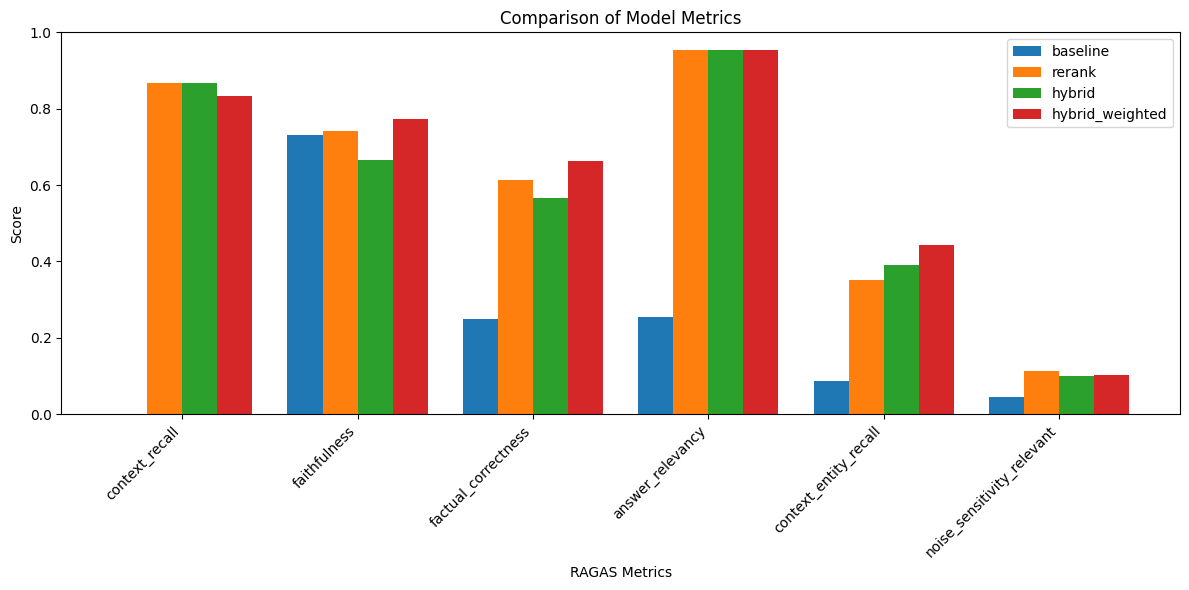

In [90]:
import numpy as np
import matplotlib.pyplot as plt

baseline = {'context_recall': 0.0000, 'faithfulness': 0.7318, 'factual_correctness': 0.2482, 'answer_relevancy': 0.2541, 'context_entity_recall': 0.0877, 'noise_sensitivity_relevant': 0.0455}
rerank = {'context_recall': 0.8680, 'faithfulness': 0.7411, 'factual_correctness': 0.6145, 'answer_relevancy': 0.9534, 'context_entity_recall': 0.3524, 'noise_sensitivity_relevant': 0.1121}
hybrid = {'context_recall': 0.8680, 'faithfulness': 0.6654, 'factual_correctness': 0.5664, 'answer_relevancy': 0.9531, 'context_entity_recall': 0.3915, 'noise_sensitivity_relevant': 0.1014}
hybrid_weighted = {'context_recall': 0.8323, 'faithfulness': 0.7721, 'factual_correctness': 0.6618, 'answer_relevancy': 0.9544, 'context_entity_recall': 0.4437, 'noise_sensitivity_relevant': 0.1025}
dicts = [baseline, rerank, hybrid, hybrid_weighted]
labels = ['baseline', 'rerank', 'hybrid', 'hybrid_weighted']

metrics = list(baseline.keys())
x = np.arange(len(metrics))
width = 0.2 

fig, ax = plt.subplots(figsize=(12, 6))

for i, d in enumerate(dicts):
    values = [d[m] for m in metrics]
    ax.bar(x + i * width, values, width, label=labels[i])

# Formatting
ax.set_xlabel('RAGAS Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Model Metrics')
ax.set_xticks(x + width * (len(dicts) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()

### Activity #1 Findings:

*Document your findings here: What strategy did you try? How did it compare to the baseline and reranking results?*

The baseline ( blue bar) did not work well at all. The small chunk size and overlap meant 
Any ajustments seem to improve the baseline on most metrics, with the exception of noise_sensitivity_relevant (where lower is better), but only because there was so little information provided in the retreived chunks of the baseline method there was no room for noise).

Rerank (in orange) is quite an improvement over baseline, and actually **adding** the hybrid search makes the metrics  worse. Evidently keyword-style matching is not a great fit for the queries in our evaluation set. 

However, when I weight the metrics towards semantic search - 70-30 split - it works really well on faithfullness and factual correctness and context_entity recall, although we get some poorer performance on context recall.


For this kind of application

Of course adding re-ranking and sparse vector search adds to the computational load, and so to query latency and cost, so there are tradeoffs to be made by being more sophisticated.



